# Parallélisation sur CPU d'une séquence d'opérations matricielles extraites d'un modèle Llama

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from sigmulib import compute_sigmul_cpp, compute_sigmul_cython

from utils import *

torch.manual_seed(29)

## Partie 1: Visualisation de l'effet de la parallélisation

In [2]:
dims = [2**i for i in range(10)]
all_times_1 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch', 'sigmul_sequential'])
diffs_1 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_sequential'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10, include_sequential=True)
    for key in times.keys():
        all_times_1.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_1.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs_1.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs_1.loc[dim, 'sigmul_sequential'] = torch.abs(Bt - torch.tensor(unparallel_sigmul(A))).sum().item() / (dim**2)


100%|██████████| 10/10 [02:16<00:00, 13.63s/it]


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

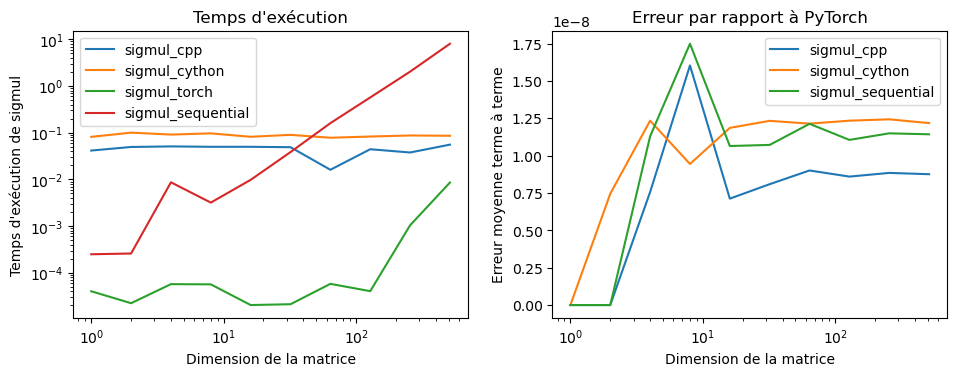

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_1.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_1.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

Conclusion : méthode séquentielle : temps d'exécution quadratique avec la dimension, parallélisation qui fonctionne bien. Echelles logarithmiques sur les axes. Quasi aucune erreur par rapport à Torch.

## Partie 2: Comparaison des implémentations parallélisées de sigmul

In [21]:
dims = [2**i for i in range(15)]
all_times_2 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch'])
diffs_2 = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10)
    for key in times.keys():
        all_times_2.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_2.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs_2.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


100%|██████████| 15/15 [07:20<00:00, 29.35s/it] 


Text(0.5, 1.0, 'Erreur par rapport à PyTorch')

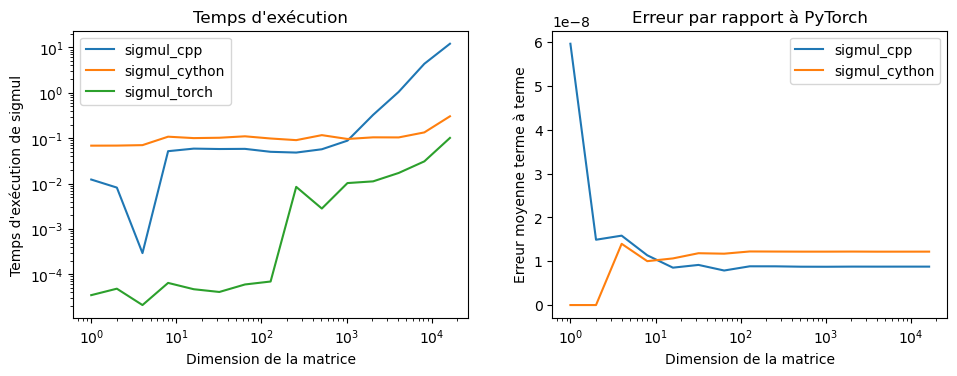

In [24]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_2.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_2.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

Conclusion : la méthode 'full cython' marche beaucoup mieux que celle basée sur C++, dont les temps de calculs explosent. On retient donc seulement la version Cython, et on essaie d'aller plus loin dans la comparaison avec torch.

## Partie 3: Comparaison plus poussée des implémentations en Cython et en PyTorch 

In [25]:
dims = [2**i for i in range(16)]
all_times_3 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_torch'])
diffs_3 = pd.DataFrame(index=dims, columns=['sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10, include_cpp=False)
    for key in times.keys():
        all_times_3.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_3.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


 89%|████████▉ | 16/18 [09:57<05:18, 159.11s/it]

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_3.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_3.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

In [ ]:
all_times_3['ratio'] = all_times_3['sigmul_cython'] / all_times_3['sigmul_torch']

In [ ]:
fig, ax = plt.subplot()
fig.set_size_inches(5, 4)

all_times_3['ratio'].plot(logx=True, logy=True, ax=ax)
ax.set_xlabel("Dimension de la matrice")
ax.set_ylabel("Ratio cython / torch")
ax.set_title("Ratios des temps d'exécution")

Conclusion : le ratio diminue fortement, les erreurs restent faibles. Cependant, on a omis le coût de conversion tensor->np.array, non négligeable avec des grands arrays, et nécessaire si l'on veut réellement inclure la fonction dans le modèle.

## Partie 4: Prise en compte des temps de conversion des types entre C++ et PyTorch

In [ ]:
dims = [2**i for i in range(14)]
all_times_4 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_conversions', 'sigmul_torch'])
diffs_4 = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_cython_conversions'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=20, include_cpp=False, include_conv_cython=True)
    for key in times.keys():
        all_times_4.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs_4.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    diffs_4.loc[dim, 'sigmul_cython_conversions'] = torch.abs(Bt - sigmul_from_tensor_cython(A)).sum().item() / (dim**2)


In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=3)

all_times_4.plot(logx=True, logy=True, ax=axes[0])
axes[0].set_xlabel("Dimension de la matrice")
axes[0].set_ylabel("Temps d'exécution de sigmul")
axes[0].set_title("Temps d'exécution")

diffs_4.plot(logx=True, ax=axes[1])
axes[1].set_xlabel("Dimension de la matrice")
axes[1].set_ylabel("Erreur moyenne terme à terme")
axes[1].set_title("Erreur par rapport à PyTorch")

Conclusion : lorsque l'on prend en compte les temps de conversion des types (PyTorch -> C++ -> PyTorch), la version Cython de sigmul devient beaucoup plus coûteuse. Il n'y a donc pas de gain temporel à l'insérer dans le modèle Llama.